In [1]:
# file wrapper-concept.ipynb
# author Jim Smith Jan 2022
# note book to explore and illustrate the basic concept of a wrapper class

## Edited Andy McCarthy Feb 2022 to adapt to illustrate the use of safe_random_forest class
# params protected are boostrap==True and min_samples_leaf = 5

# edit jim Smith Feb 18 to use multple inheritance vesion of safemodels

In [2]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [3]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target


# print the max and min values in each feature to help hand-craft the disclosive point
for feature in range(4):
    print(f"feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}")

# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X, (7, 2.0, 4.5, 1)])
y = np.append(y, 4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same results as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0
Fairly randomly selecting two of the trees in the forest to display


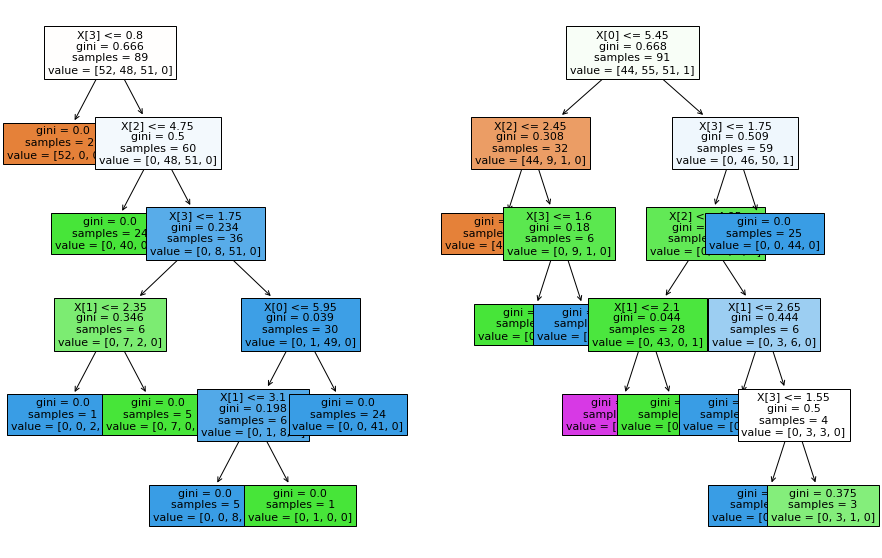

In [5]:
# example code with no safety

from sklearn.ensemble import RandomForestClassifier

rawRF = RandomForestClassifier(max_depth=5, random_state=1)
rawRF.fit(X, y)

print(f"Training set accuracy in this naive case is {rawRF.score(X,y)}")
print("Fairly randomly selecting two of the trees in the forest to display")

estimator = rawRF.estimators_[5]
estimator1 = rawRF.estimators_[50]

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
_ = plot_tree(estimator, filled=True, ax=ax[0], fontsize=11)
_ = plot_tree(estimator1, filled=True, ax=ax[1], fontsize=11)

### As we can see we have several disclosive nodes, one of which is our added point (in purple)

- A single tree that has a leaf corresponding to our new point may not give tight bounds on every feature value
- But every additional tree restricts those bounds - especially if each uses different combinations of features
- so the risk of complete disclosure of that point increases.


### Diligent user realises problem, and changes their code to see if enforcing at least n samples in each leaf and/or  bootstrapping helps
- We'll use n=5 
- note that we need to combination of both of these

## Scenario. 1: Boostrap=True and min_samples_leaf = 1:  low MIA risk (per Simon) but singleton disclosure 

Training set accuracy in scenario 1 is 1.0


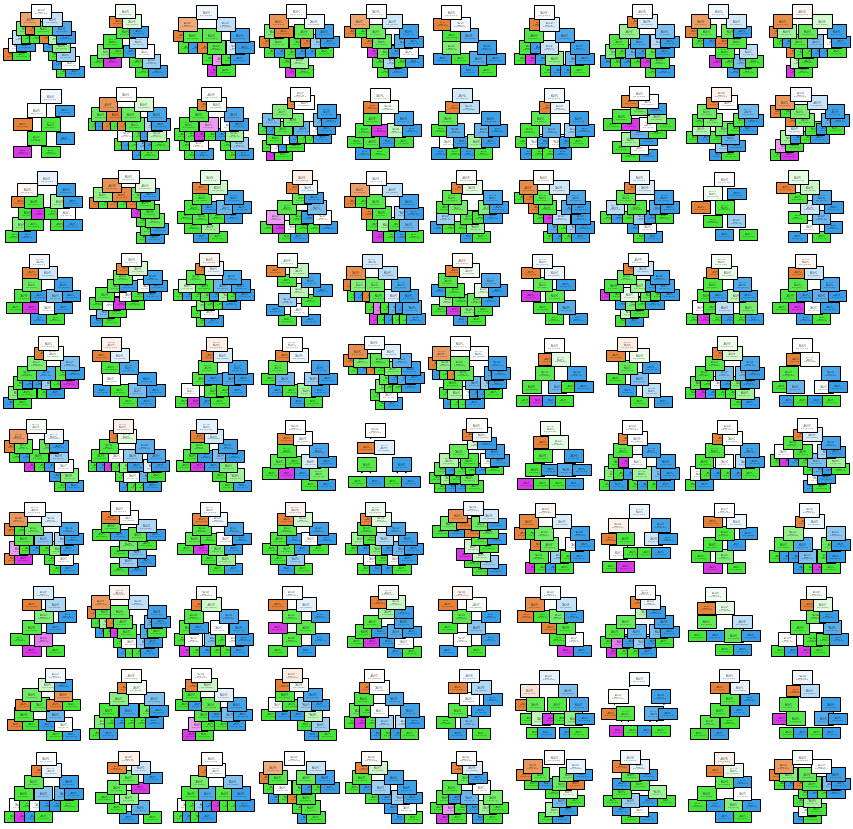

In [6]:
manualRF1 = RandomForestClassifier(bootstrap=True, min_samples_leaf=1, random_state=1)
manualRF1.fit(X, y)
print(f"Training set accuracy in scenario 1 is {manualRF1.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF1.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Scenario 2: Boostrap=True and min_samples_leaf = 5: no singleton disclosure  high MIA risk  (per Simon)

Training set accuracy in scenario 2 is 0.9668874172185431


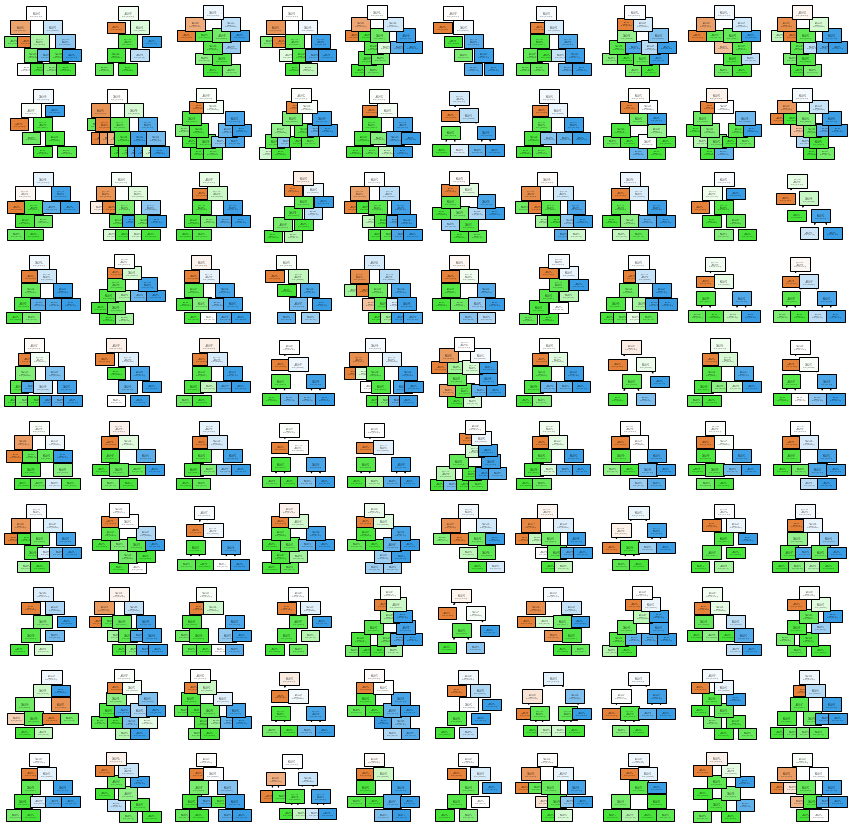

In [7]:
manualRF2 = RandomForestClassifier(bootstrap=True, min_samples_leaf=5, random_state=1)
manualRF2.fit(X, y)
print(f"Training set accuracy in scenario 2 is {manualRF2.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF2.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Scenario 3: Boostrap=True and min_samples_leaf = 5: no singleton disclosure, low MIA risk (per Simon)

Training set accuracy in scenario 3 is 0.9668874172185431


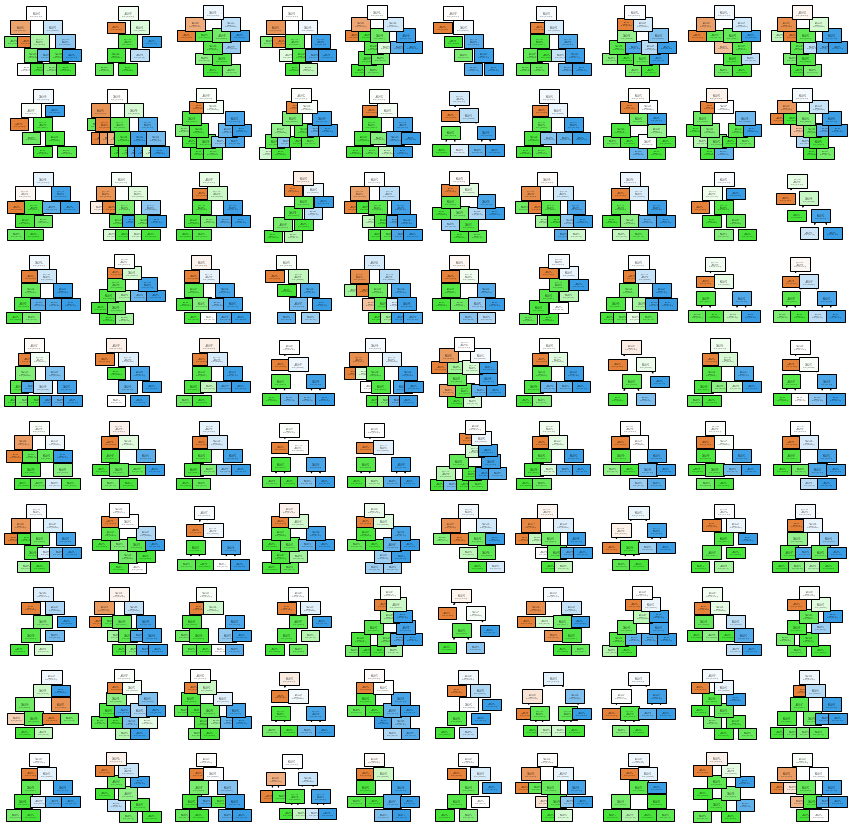

In [8]:
manualRF3 = RandomForestClassifier(bootstrap=True, min_samples_leaf=5, random_state=1)
manualRF3.fit(X, y)
print(f"Training set accuracy in scenario 3 is {manualRF3.score(X,y)}")
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = manualRF3.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

### This shows we need both parameters to. be set for the output to be non-disclosive
- Simon has shown elsewhere Bootstrap =False leads to high MIA risk
- middle plot shows even bootstrap = True can lead to multiple trees with singleton leaves which pose individual disclosure risk
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeRandomForestClassifier 

In [9]:
from safemodel.safemodel import SafeModel
from safemodel.classifiers import SafeRandomForestClassifier

In [10]:
noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

None with parameters: {'model_type': 'None', 'model': None, 'saved_model': None, 'model_save_file': 'None', 'ignore_items': [], 'examine_seperately_items': [], 'filename': 'None', 'researcher': 'andy'}


In [11]:
safeRFModel = SafeRandomForestClassifier(n_estimators=100)  # (criterion="entropy")
# print(safeRFModel.__str__())
safeRFModel.fit(X, y)

for key, value in safeRFModel.__dict__.items():
    print(f" key {key} value  {value} of type {type(value)}")

- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

 key model_type value  RandomForestClassifier of type <class 'str'>
 key model value  None of type <class 'NoneType'>
 key saved_model value  {'model_type': 'RandomForestClassifier', 'model': None, 'saved_model': None, 'model_save_file': 'None', 'ignore_items': ['model_save_file', 'ignore_items', 'estimators_', 'base_estimator_'], 'examine_seperately_items': ['base_estimator'], 'filename': 'None', 'researcher': 'andy', 'base_estimator': DecisionTreeClassifier(), 'n_estimators': 100, 'estimator_params': ('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'class_weight': None, 'max_samples': None, 'criterion': 'gini', '

Training set accuracy in this safe case is 0.9668874172185431
Not the same as last time because I have not specified the random state and here are  the trees again


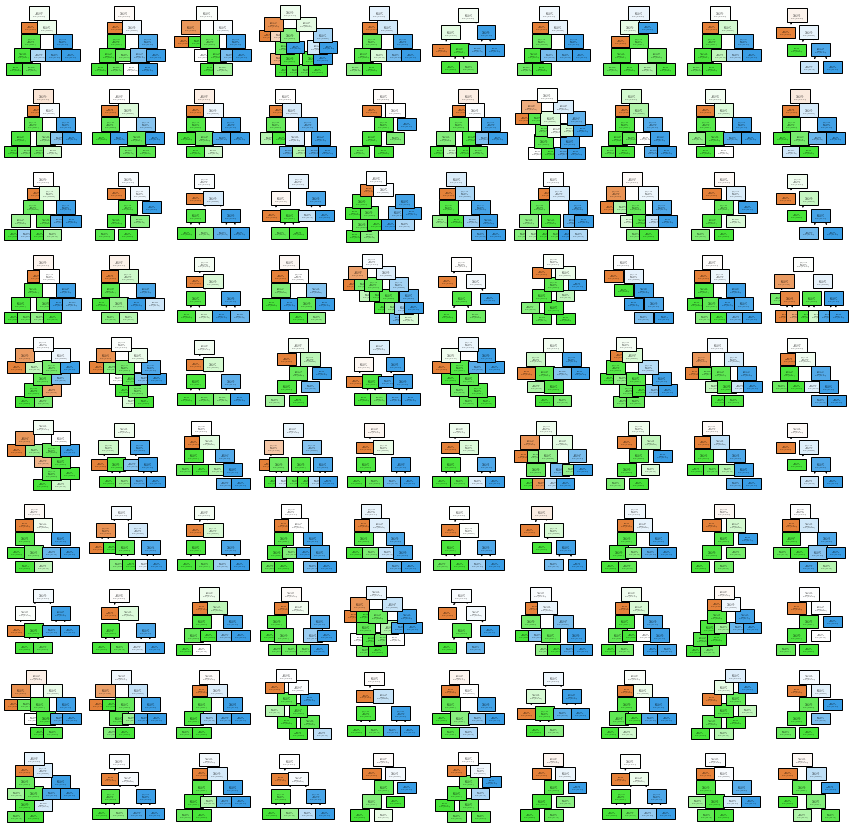

In [12]:
safeRFModel.fit(X, y)

print(f"Training set accuracy in this safe case is {safeRFModel.score(X,y)}")
print(
    "Not the same as last time because I have not specified the random state and here are  the trees again"
)

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = safeRFModel.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

## Now demonstrate the save and reporting functionality

In [13]:
# for i in range (len(safeRFModel.estimators_)):
#    print(safeRFModel.estimators_[i])
#    print(safeRFModel.savedModel['estimators_'][i])
# print(type(safeRFModel.base_estimator))
# print(type(safeRFModel.savedModel['base_estimator']))


msg, disclosive = safeRFModel.posthoc_check()
print(f"posthoc check says disclosive is {disclosive} with message {msg}")

posthoc check says disclosive is False with message 


In [14]:
safeRFModel.save(name="testSaveRF.pkl")
safeRFModel.preliminary_check()
safeRFModel.request_release("testSaveRF.pkl")

Model parameters are within recommended ranges.



## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [15]:
print(safeRFModel.__dict__)

{'model_type': 'RandomForestClassifier', 'model': None, 'saved_model': {'model_type': 'RandomForestClassifier', 'model': None, 'saved_model': {'model_type': 'RandomForestClassifier', 'model': None, 'saved_model': None, 'model_save_file': 'None', 'ignore_items': ['model_save_file', 'ignore_items', 'estimators_', 'base_estimator_'], 'examine_seperately_items': ['base_estimator'], 'filename': 'None', 'researcher': 'andy', 'base_estimator': DecisionTreeClassifier(), 'n_estimators': 100, 'estimator_params': ('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'class_weight': None, 'max_samples': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'max_lea

Training set accuracy in this naive case is 1.0
you can see there are now unsafe trees again


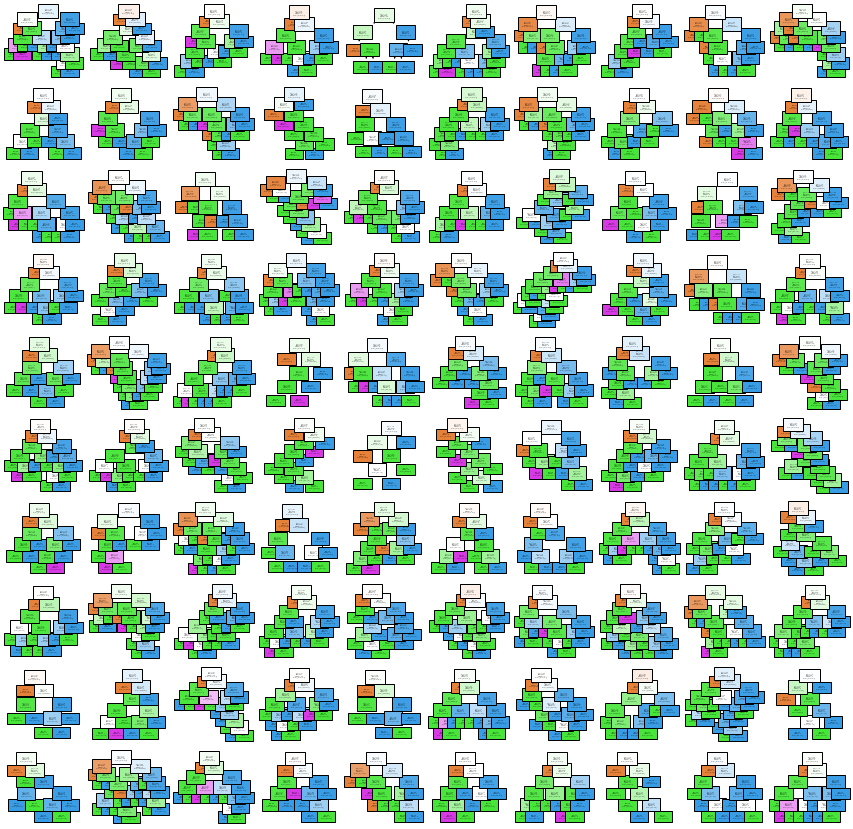

In [16]:
safeRFModel.min_samples_leaf = 1

safeRFModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeRFModel.score(X,y)}")
print("you can see there are now unsafe trees again")

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for row in range(10):
    for column in range(10):
        whichTree = 10 * row + column
        treeRowCol = safeRFModel.estimators_[whichTree]
        _ = plot_tree(treeRowCol, filled=True, ax=ax[row][column], fontsize=1)

### This has let the user reset the params so that the model is now disclosive once again.

## Question: what do we do here:
1. Find a way of obfuscating the params so that they cannot be changed from outside the wrapper class
  - hard, not very python esque
  - also what if the use wants to increase min_samples_leaf which would make the model less disclosive than the default values?
  - **we've discarded this approach as impractical**
2. Put code into various method within the main class that checks the param values and says if they have been changed.
 - constraints are  stored the "safe" param values in a read-only file  
   and reads that into a dict in the init() and preliminary_check() and request_release() methods. 
    - The dict key is name of parameter name, value is a tuple of [operator, value]  
      where operator is one of ["min" |"equals" | "max"] and value is applied to operator
    - the dict is read afresh in __init__() and in make_report() to prevent users amending values 
 - this would have the benefit of allowing users to increase the min_samples_leaf but report when it was taken below our threshold
 
 - issue is how to deal with situations where the safety is built from a non-linear interaction between param values
   - that is a problem to deal with in the second stage of the project once we have proved the concept
 

In [17]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeRFModel2 = SafeRandomForestClassifier()
safeRFModel2.fit(X, y)
safeRFModel2.save(name="safe2.pkl")
safeRFModel2.preliminary_check()
safeRFModel2.request_release(filename="safe2.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeRFModel3 = SafeRandomForestClassifier()
safeRFModel3.min_samples_leaf = 6
safeRFModel3.fit(X, y)
safeRFModel3.save(name="safe3.pkl")
safeRFModel3.preliminary_check()
safeRFModel3.request_release(filename="safe3.pkl")


# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeRFModel4 = SafeRandomForestClassifier()
safeRFModel4.bootstrap = False
safeRFModel4.fit(X, y)
safeRFModel4.save(name="unsafe1.pkl")
safeRFModel4.preliminary_check()
safeRFModel4.request_release(filename="unsafe1.pkl")


# change another model params in an  unsafe way
print("\n***Test 4: researcher changes numeric params unsafely")
safeRFModel5 = SafeRandomForestClassifier()
safeRFModel5.bootstrap = True
safeRFModel5.min_samples_leaf = 2
safeRFModel5.save(name="unsafe2.pkl")
safeRFModel5.preliminary_check()
safeRFModel5.request_release(filename="unsafe2.pkl")

# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")
safeRFModel6 = SafeRandomForestClassifier()
safeRFModel6.bootstrap = False
safeRFModel6.min_samples_leaf = 2
safeRFModel6.save(name="unsafe3.pkl")
safeRFModel6.preliminary_check()
safeRFModel6.request_release(filename="unsafe3.pkl")

***Test 1: researcher doesn't change recommended params
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Model parameters are within recommended ranges.


***Test 2: researcher changes params safely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Model parameters are within recommended ranges.


***Test 3: researcher changes string params unsafely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

- parameter bootstrap = False identified as different than the recommended fixed value of True.

***Test 4: researcher changes numeric params unsafely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

- parameter min_samples_leaf = 2 identified as less than the recommended min

In [18]:
# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeRFModel7 = SafeRandomForestClassifier()
safeRFModel7.bootstrap = False
safeRFModel7.min_samples_leaf = 2
safeRFModel7.save(name="unsafe4.pkl")
safeRFModel7.preliminary_check(apply_constraints=False)
safeRFModel7.request_release(filename="unsafe4.pkl")


***Test 6: researcher changes string and numeric params unsafely
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

- parameter bootstrap = False identified as different than the recommended fixed value of True.- parameter min_samples_leaf = 2 identified as less than the recommended min value of 5.


In [19]:
!echo "contents of checkfile are"; cat *_check*ile.json

contents of checkfile are
{
    "researcher": "andy",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "testSave.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file testSave.pkl through next step of checking procedure"
}{
    "researcher": "andy",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe2.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file safe2.pkl through next step of checking procedure"
}{
    "researcher": "andy",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe3.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file safe3.pkl through next step of checking procedure"
}{
    "researcher": "andy",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "safe4.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recomme

    "reason": "Model parameters are within recommended ranges.\nError: user has not called fit() method or has deleted saved values.Recommendation: Do not release. The model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been run; however, epsilon is not sufficient for Differential privacy: 13.508764316908554. You must modify one or more of batch_size, epochs, number of samples."
}{
    "researcher": "andy",
    "model_type": "KerasModel",
    "model_save_file": "None",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Do not allow release",
    "reason": "Model parameters are within recommended ranges.\nError: user has not called fit() method or has deleted saved values.Recommendation: Do not release. The model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been run; however, epsilon is not sufficient for Differential privacy: 13.5087